##Preprocessing

Output: X_test, X_train, y_test, y_train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
!rm -rf ./logs/ 

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv3D, Concatenate, MaxPooling3D, Dense, Activation, Permute, Dropout, SeparableConv2D, DepthwiseConv2D, BatchNormalization, SpatialDropout2D, ZeroPadding3D, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import scipy.io

filepath = "/content/drive/MyDrive/BCI project/Python stuf/JakobProcessedData.npy"
data = np.load(filepath, allow_pickle = True)


In [ ]:
if data.shape[:2] != (450, 32):
  print("Preprocessing is wrong")

## Preprocess Labels

In [ ]:
labels_1 = scipy.io.loadmat('/content/drive/MyDrive/BCI project/Python stuf/classrun1_3class.mat')
labels_2 = scipy.io.loadmat('/content/drive/MyDrive/BCI project/Python stuf/classrun2_3class.mat')
labels_3 = scipy.io.loadmat('/content/drive/MyDrive/BCI project/Python stuf/classrun3_3class.mat')
labels_4 = scipy.io.loadmat('/content/drive/MyDrive/BCI project/Python stuf/classrun4_3class.mat')

In [ ]:
y_1 = np.zeros_like(labels_1['z1'][0])
for index, gesture in enumerate(labels_1['z1']):
  for index_2, number in enumerate(gesture):
    if number == 1:
      y_1[index_2] = index


In [ ]:
y_2 = np.zeros_like(labels_2['z2'][0])
for index, gesture in enumerate(labels_2['z2']):
  for index_2, number in enumerate(gesture):
    if number == 1:
      y_2[index_2] = index

In [ ]:
y_3 = np.zeros_like(labels_3['z3'][0])
for index, gesture in enumerate(labels_3['z3']):
  for index_2, number in enumerate(gesture):
    if number == 1:
      y_3[index_2] = index

In [ ]:
y_4 = np.zeros_like(labels_4['z4'][0])
for index, gesture in enumerate(labels_4['z4']):
  for index_2, number in enumerate(gesture):
    if number == 1:
      y_4[index_2] = index

In [ ]:
final_y = np.concatenate((y_1, y_2, y_3, y_4, y_1, y_2, y_3, y_4, y_1, y_2))

##Creating 3D array

In [ ]:
front = np.zeros((6,7))
front[0][2] = 1
front[0][4] = 2
front[0][1] = 3
front[0][5] = 4
front[1][0] = 5
front[1][2] = 6
front[1][3] = 7
front[1][4] = 8
front[1][6] = 9
front[1][1] = 10
front[2][2] = 11

front[2][4] = 12
front[1][5] = 13
front[2][0] = 14
front[2][1] = 15
front[2][3] = 16

front[2][5] = 17
front[2][6] = 18
front[3][1] = 19
front[3][2] = 20
front[3][4] = 21
front[3][5] = 22

front[4][0] = 23
front[4][2] = 24
front[4][3] = 25
front[4][4] = 26
front[4][6] = 27

front[5][0] = 28
front[5][1] = 29
front[5][5] = 30
front[5][6] = 31
front[5][3] = 32

front.reshape(6,7,1)

print(front)
total_array = np.zeros((6,7,data[0].shape[1]))
total_array[:,:,0] = front

[[ 0.  3.  1.  0.  2.  4.  0.]
 [ 5. 10.  6.  7.  8. 13.  9.]
 [14. 15. 11. 16. 12. 17. 18.]
 [ 0. 19. 20.  0. 21. 22.  0.]
 [23.  0. 24. 25. 26.  0. 27.]
 [28. 29.  0. 32.  0. 30. 31.]]


In [ ]:
final_list = []
for trial in data:
  if trial.shape != (32, 2134):
    print("Problem!")
  total_array = np.zeros((6,7,trial.shape[1]))
  total_array[:,:,0] = front
  for index, row in enumerate(trial):
    if index != 0 and index != 31:
      total_array[np.where(front == index)] = row
  final_list.append(total_array)

In [ ]:
#Test if the shapes are what we expect them to be
for index, item in enumerate(final_list):
  if item.shape != (6, 7, 2134):
    print("Problem at " + str(index))
print("Done")

Done


##Branched Model

Trains three branched models at 15, 50 and 100 epochs

In [ ]:
#The order of the trials is already randomized, so we do not need to shuffle in the k-fold split
from sklearn.model_selection import KFold, StratifiedKFold
X = input3d.reshape(450, 1, 6, 7, 2134)
enc=preprocessing.OneHotEncoder().fit(final_y.reshape((-1,1)))
Y=enc.transform(final_y.reshape((-1,1))).toarray()
acc_per_fold = []

loss_per_fold = []
kfold = KFold(n_splits=10)

for epoch in [15, 50,100]:
# K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, Y):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    num_labels = 3
    #First 3D conv layer
    #Input shape excludes the first dimension, which is batch shape
    inputs = Input(shape = (1,6,7,2134))
    v = inputs
    #Pay special attention to put the activation behind the Batch Normalization layer
    v = ZeroPadding3D(padding = (0,4,4))(v)
    v = Conv3D(filters = 16, kernel_size = (3,3,5), strides=(2,2,4), activation = None, data_format = "channels_first")(v)
    v = BatchNormalization()(v)
    v = Activation("elu")(v)
    #SRF
    left_inputs = v
    x = left_inputs
    x = ZeroPadding3D(padding = (0,3,0))(x)
    x = Conv3D(filters = 32, kernel_size = (2,2,1), strides=(2,2,1), activation = None)(x)

    x = BatchNormalization()(x)
    x = Activation("elu")(x)

    x = ZeroPadding3D(padding = (0,3,0))(x)

    x = Conv3D(filters = 64, kernel_size = (2,2,1), strides=(2,2,1),activation = None)(x)

    x = BatchNormalization()(x)
    x = Activation("elu")(x)

    x = Flatten()(x)

    x = Dense(32, activation= None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Dense(32, activation= None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    srf_out = Dense(num_labels , activation = 'softmax')(x)

    #MRF
    mid_inputs = v
    y = mid_inputs
    y = ZeroPadding3D(padding = (0,3,4))(y)
    y = Conv3D(filters = 32, kernel_size = (2,2,3), strides=(2,2,2), activation = None)(y)

    y = BatchNormalization()(y)
    y = Activation("elu")(y)

    y = ZeroPadding3D(padding = (0,3,4))(y)
    y = Conv3D(filters = 64, kernel_size = (2,2,3), strides=(2,2,2), activation = None)(y)
    y = BatchNormalization()(y)
    y = Activation("elu")(y)

    y = Flatten()(y)

    y = Dense(32, activation= None)(y)

    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = Dense(32, activation= None)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    mrf_out = Dense(num_labels , activation = 'softmax')(y)

    #LRF
    right_inputs = v
    z = right_inputs

    z = ZeroPadding3D(padding = (0,3,12))(z)
    z = Conv3D(filters = 32, kernel_size = (2,2,5), strides=(2,2,4), activation = None)(z)
    z = BatchNormalization()(z)
    z = Activation("elu")(z)

    z = ZeroPadding3D(padding = (0,3,12))(z)
    z = Conv3D(filters = 64, kernel_size = (2,2,5), strides=(2,2,4), activation = None)(z)
    z = BatchNormalization()(z)
    z = Activation("elu")(z)

    z = Flatten()(z)

    z = Dense(32, activation= None)(z)
    z = BatchNormalization()(z)
    z = Activation("relu")(z)

    z = Dense(32, activation= None)(z)
    z = BatchNormalization()(z)
    z = Activation("relu")(z)

    lrf_out = Dense(num_labels , activation = 'softmax')(z)

    #now lets merge the 3 networks
    r = Concatenate()([srf_out,mrf_out,lrf_out])

    r = Flatten()(r)

    outputs = Dense(num_labels, activation ="softmax")(r)

    model = tf.keras.Model(inputs, outputs)

    #Initialize model
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    model.summary()
    # Fit data to model
    history = model.fit(X[train], Y[train], epochs=epoch, batch_size = 16, callbacks=[tensorboard_callback])

    # Generate generalization metrics
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1


In [ ]:
#model.summary()
#filepath = "/content/drive/MyDrive/BCI project"
#plot_model(model, to_file=os.path.join(filepath, '3 branch cnn.png'), show_shapes=True)


##EEGNet
Trains two models at 50 and 100 epochs

In [ ]:
#Taken directly from Lawhern et al. (2018)
#Filter sizes doubled for 250 Herz samples

def EEGNet(nb_classes, Chans = 32, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))
    print(input1.shape)
    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    print(block1.shape)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 8))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 32),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 16))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [ ]:
#The order of the trials is already randomized, so we do not need to shuffle in the k-fold split
from sklearn.model_selection import KFold, StratifiedKFold
input_data = data[:, 1:31, :]
input_data = np.moveaxis(input_data, 0, -1)
X = input_data.reshape(450, 30, 2134, 1)
enc=preprocessing.OneHotEncoder().fit(final_y.reshape((-1,1)))
Y=enc.transform(final_y.reshape((-1,1))).toarray()
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=10)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, Y):
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  
  C = 30
  T = data.shape[2]
  #Kernlength is half the sample rate
  kernlength = 125
  model = EEGNet(3, Chans = C, Samples = T, kernLength=kernlength)

  model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
  model.summary()
  # Fit data to model
  history = model.fit(X[train], Y[train], epochs=100, batch_size = 16)

  # Generate generalization metrics
  scores = model.evaluate(X[test], Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1



##Plotting Bad Channels

In [ ]:
colorlist = []
x = np.linspace(0, 5, 100)
cmap = plt.get_cmap('viridis')
N = 30
for i, n in enumerate(np.linspace(2.0, 0, N)):
    y = np.sin(x)*x**n
    colorlist.append(cmap(float(i)/N))

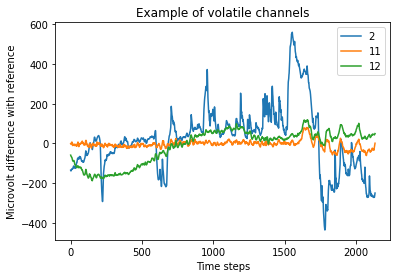

In [ ]:
df = pd.DataFrame(data[3])

df.iloc[2].plot()
df.iloc[11].plot()
df.iloc[12].plot()
plt.title("Example of volatile channels")
plt.ylabel("Microvolt difference with reference")
plt.xlabel("Time steps")
plt.legend()
plt.show()



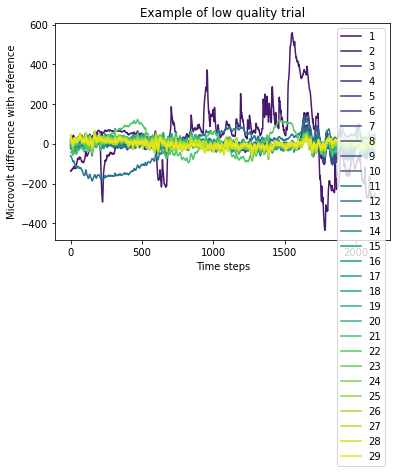

In [ ]:
df = pd.DataFrame(data[3])
for i in range(1,30):
  df.iloc[i].plot(c = colorlist[i])
plt.title("Example of low quality trial")
plt.ylabel("Microvolt difference with reference")
plt.xlabel("Time steps")
plt.legend()
plt.show()

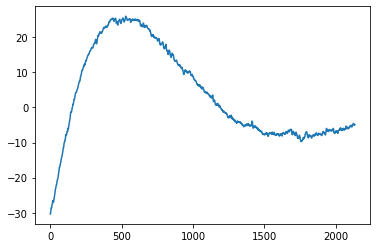

In [ ]:
df.iloc[3].plot()